In [1]:
from io import open
import glob
import unicodedata
import string

In [2]:
def find_files(path):
    return glob.glob(path)

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters) + 1 # EOS marker

In [3]:
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c)!='Mn' and c in all_letters)

In [4]:
category_lines = {}
all_categories = []
def read_lines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicode_to_ascii(line) for line in lines]

for filename in find_files('data/names/*.txt'):
    category = filename.split('/')[-1].split('.')[0]
    all_categories.append(category);
    lines = read_lines(filename)
    category_lines[category] = lines
    
print(all_categories)    
n_categories = len(all_categories)

['Italian', 'Irish', 'Indian', 'Vietnamese', 'Scottish', 'Chinese', 'Japanese', 'Greek', 'Russian', 'English', 'Dutch', 'Polish', 'German', 'French', 'Portuguese', 'Czech', 'Korean', 'Spanish', 'Arabic']


In [5]:
import torch
import torch.nn as nn
from torch.autograd import Variable

In [6]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        
        self.i_h = nn.Linear(n_categories+input_size+hidden_size, hidden_size)
        self.tanh = nn.Tanh()
        self.i_o = nn.Linear(n_categories+input_size+hidden_size, output_size)
        self.o_o = nn.Linear(hidden_size+output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax()
        
    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i_h(input_combined)
        output = self.i_o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        hidden = self.tanh(hidden)
        output = self.o_o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden
    
    def init_hidden(self):
        return Variable(torch.zeros(1, self.hidden_size))

In [7]:
import random

def random_choice(l):
    return l[random.randint(0, len(l)-1)]

def random_training_pair():
    category = random_choice(all_categories)
    line = random_choice(category_lines[category])
    return category, line

In [8]:
def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

def targetTensor(line):
    letter_indices = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indices.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indices)

In [9]:
def random_training_example():
    category, line = random_training_pair()
    category_tensor = Variable(categoryTensor(category))
    input_line_tensor = Variable(inputTensor(line))
    target_line_tensor = Variable(targetTensor(line))
    return category_tensor, input_line_tensor, target_line_tensor

In [10]:
criterion = nn.NLLLoss()
lr = 0.0005

def train(category_tensor, input_line_tensor, target_line_tensor):
    hidden = rnn.init_hidden()
    rnn.zero_grad()
    loss = 0
    for i in range(input_line_tensor.size()[0]):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        loss += criterion(output, target_line_tensor[i])
        
    loss.backward()
    
    for p in rnn.parameters():
        p.data.add_(-lr, p.grad.data)
        
    return output, loss.data[0]/input_line_tensor.size()[0]

In [11]:
import time
import math

def time_since(since):
    now = time.time()
    s = now - since
    m = math.floor(s/60)
    s -= m*60
    return '%dm %ds'%(m,s)

In [12]:
rnn = RNN(n_letters, 128, n_letters)

In [13]:
n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0
start = time.time()

for iter in range(1, n_iters+1):
    output, loss = train(*random_training_example())
    total_loss += loss
    
    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (time_since(start), iter, iter / n_iters * 100, loss))
    
    if iter % plot_every == 0:
        all_losses.append(total_loss/plot_every)
        total_loss = 0

0m 41s (5000 5%) 2.6539
1m 20s (10000 10%) 2.4337
1m 59s (15000 15%) 2.2355
2m 39s (20000 20%) 3.0525
3m 18s (25000 25%) 2.5565
3m 58s (30000 30%) 2.4174
4m 38s (35000 35%) 2.5491
5m 18s (40000 40%) 2.5886
5m 57s (45000 45%) 2.3247
6m 37s (50000 50%) 2.5209
7m 17s (55000 55%) 3.0726
7m 56s (60000 60%) 2.3291
8m 36s (65000 65%) 3.0607
9m 15s (70000 70%) 2.2793
9m 55s (75000 75%) 2.3428
10m 35s (80000 80%) 2.1275
11m 15s (85000 85%) 2.0782
11m 54s (90000 90%) 2.7817
12m 34s (95000 95%) 2.5552
13m 14s (100000 100%) 3.0939


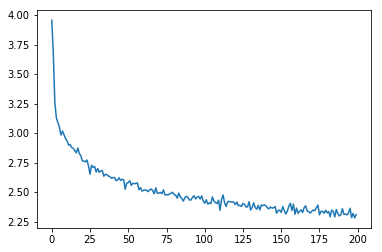

In [14]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.plot(all_losses)
plt.show()

In [15]:
max_length = 20

def sample(category, start_letter='A'):
    category_tensor = Variable(categoryTensor(category))
    input = Variable(inputTensor(start_letter))
    hidden = rnn.init_hidden()
    output_name = start_letter
    
    for i in range(max_length):
        output, hidden = rnn(category_tensor, input[0], hidden)
        topv, topi = output.data.topk(1)
        topi = topi[0][0]
        if topi == n_letters-1:
            break
        else:
            letter = all_letters[topi]
            output_name += letter
        input = Variable(inputTensor(letter))
        
    return output_name

def samples(category, start_letters='ABC'):
    print(category, ':')
    for start_letter in start_letters:
        print(sample(category, start_letter))

In [22]:
samples('Russian', 'RUSSIAN')

Russian :
Roverik
Uandon
Shakinovov
Shinovon
Iantovov
Artonov
Niskin


In [23]:
samples('Indian', 'INDIAN')

Indian :
Iara
Nisha
Dian
Iani
Arthant
Naman


In [24]:
samples('Spanish', 'SPANISH')

Spanish :
Santo
Para
Allan
Nara
Iara
Santoro
Harez


In [25]:
samples('German', 'GERMAN')

German :
Geller
Eres
Rour
Manter
Arter
Neren


In [26]:
samples('French', 'FRENCH')

French :
Feller
Roure
Earerin
Naner
Carer
Harier
